In [46]:
import numpy as np
from collections import Counter
import pandas as pd
import re
import datetime
import sys
from glob import glob
import seaborn as sns
from IPython.display import Latex
from IPython.display import Image
import gensim
from scipy import spatial
import multiprocessing
from gensim.models.doc2vec import Doc2Vec, LabeledSentence
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
# from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from urllib import parse
pd.set_option('display.max_columns',None)
pd.set_option('display.width', 10000)
pd.set_option('display.max_colwidth',10000)

In [15]:
def flushPrint(s):
    sys.stdout.write('\r')
    sys.stdout.write('%s' % s)
    sys.stdout.flush()

### demographic

**demographic info includes social class variable(job, income, education level, city rank), control variable(gender, age)**

In [3]:
demo=pd.read_csv('./CNNIC_Clickstream1000_Data/data/demographic.csv')

In [4]:
demo.columns 

Index(['USERID', 'GENDER', 'BIRTHDAY', 'EDU', 'JOB', 'INCOME', 'PROVINCE', 'CITY', 'ISCITY'], dtype='object')

**job**

In [5]:
job = {'学生':np.nan,'其他':np.nan,'退休':np.nan, 
       '无业、下岗、失业':1,
        '农民':2,
        '农村外出务工人员':3, 
        '产业、服务业工人':4,
        '个体户/自由职业者':5,
        '企业/公司一般职员':6,'党政机关事业单位一般职员':6,
        '专业技术人员':7,
        '企业/公司管理者':8,
        '党政机关事业单位工作者':9, '党政机关事业单位领导干部':10}
demo['job'] = [job[i] for i in demo['JOB']]

In [6]:
Counter(demo['JOB'].values)

Counter({'专业技术人员': 144,
         '个体户/自由职业者': 96,
         '产业、服务业工人': 31,
         '企业/公司一般职员': 211,
         '企业/公司管理者': 98,
         '党政机关事业单位一般职员': 94,
         '党政机关事业单位工作者': 2,
         '党政机关事业单位领导干部': 25,
         '其他': 63,
         '农村外出务工人员': 21,
         '农民': 6,
         '学生': 175,
         '无业、下岗、失业': 22,
         '退休': 12})

**income**

In [7]:
inc = ['无收入', '500元及以下','501～1000元','1001～1500元',
 '1501～2000元',  '2001～3000元','3001～5000元',
 '5001～8000元','8001～12000元',   '12000元以上' ]
inc = {i: k+1 for k, i in enumerate(inc)}
demo['income'] = [inc[i] for i in demo['INCOME']]

In [10]:
Counter(demo['income'].values)

Counter({1: 148,
         2: 24,
         3: 34,
         4: 66,
         5: 115,
         6: 222,
         7: 226,
         8: 97,
         9: 39,
         10: 29})

**education**

In [8]:
edu = ['小学及以下','初中','高中/中专/技校', '大专','大学本科','硕士及以上']
edu = {i: k+1 for k, i in enumerate(edu)}
demo['edu'] = [edu[i] for i in demo['EDU']]

In [9]:
Counter(demo['EDU'].values)

Counter({'初中': 69,
         '大专': 290,
         '大学本科': 392,
         '小学及以下': 3,
         '硕士及以上': 56,
         '高中/中专/技校': 190})

**age,gender**

In [8]:
demo['age'] = [2012-i for i in demo['BIRTHDAY']]
demo['male'] = [1 if i=='男' else 0 for i in demo['GENDER'] ]

In [9]:
demo['age'].mean(),demo['age'].std()

(31.015, 9.270313571487959)

In [10]:
Counter(demo['male'].values)

Counter({0: 224, 1: 776})

**city rank**

In [13]:
Counter(demo['ISCITY'].values) 

Counter({'unknown': 160, '乡村': 127, '城市': 640, '城郊': 73})

In [16]:
city=pd.read_excel('./city.xlsx') #based on the website https://baike.baidu.com/item/中国城市新分级名单

In [17]:
len(city)

336

In [18]:
demo['CITY']=demo.apply(lambda x: x.PROVINCE if x.PROVINCE in ['北京','上海','天津','重庆'] else x.CITY, axis=1)
city['province']=city['city'].apply(lambda x: x.split('：')[0])
city['city']=city['city'].apply(lambda x: re.sub('市','',x.split('：')[1]) if len(x.split('：'))>1 else re.sub('市','',x))
city['city']=city['city'].apply(lambda x: re.sub('地区','',x))
diction_city=dict(city[['city','rank']].values)

In [19]:
diction_city['襄樊']=4
diction_city['巢湖']=3
diction_city['昌吉']=6
diction_city['台南']=2
diction_city['石河子']=6
diction_city['莱芜']=3
diction_city['临夏']=6
diction_city['攀枝花']=6
diction_city['楚雄']=6
diction_city['黔西南']=6
diction_city['琼海']=5

In [20]:
demo['city_rank']=demo['CITY'].apply(lambda x: diction_city[x])

In [21]:
Counter(demo['city_rank'].values)

Counter({1: 64, 2: 109, 3: 180, 4: 202, 5: 230, 6: 215})

### behavior

**In our file, computer behavior records are documented by day rather than by individual. So we divide these day files into individual files.**

In [49]:
for n,name in enumerate(demo['USERID'].values): #for each individual, we aggregate his everyday behavior
    flushPrint(n)
    files=sorted(glob('./CNNIC_Clickstream1000_Data/data/behavior/*')) # there are 28 days behavior files
    for file in files:
        f=glob(file+'/*')
        for i in f:
            if name in i:
                with open(i) as f:
                    case=f.readlines()
                a=[j.split('[=]')[1].split('<=>')[1] if len(j.split('[=]'))>1 else np.nan for j in case[2:]] # in our format, we extract the exe, like qq.exe
                b=[j.split('U<=>')[1].split('[=]')[0] if 'U<=>' in j else np.nan for j in case[2:]] # in computers, if an individual uses search engine exe, then we keep the website he browses
                a=pd.DataFrame(a)
                a['b']=b
                a.to_csv('./CNNIC_Clickstream1000_Data/data/users/'+name+'.csv',mode='a+',index=False,header=False)

999

### model

In [26]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm

def projection(one, two):
    # cosine similarity
    return (1 - spatial.distance.cosine(one, two))

def cosine2angle(i):
    return np.arccos(i) / np.pi * 180 #长度换角度

In [27]:
TaggededDocument = gensim.models.doc2vec.TaggedDocument

In [28]:
category=pd.read_csv('./data/combine.csv',names=['exe','low','category']) #exe, exe.lower(), and category
diction=dict(category[['low','category']].values)

In [29]:
def urlclean(url): #keep the real name of website, like taobao
    try:
        url = parse.urlparse(url).hostname
        if url.replace('.','').isdigit(): return 'none'
        else:
            if len(url.split('.')) >=2 :
                if url[-6:]=='com.cn': return '.'.join(url.split('.')[-3:])
                return '.'.join(url.split('.')[-2:])
    except:
        return 'none'

In [32]:
files=glob('./CNNIC_Clickstream1000_Data/data/users/*.csv') # there are 980 individual behavior files
freq=[]
for i,f in enumerate(files[:10]):
    flushPrint(i)
    data=pd.read_csv(f,names=['exe','http'])
    data['final']=data.apply(lambda x: x['exe'] if type(x.http)==float else x.http, axis=1) #replace search engine with specific website
    data['final']=data['final'].apply(lambda x: urlclean(x) if type(x)==str else x) 
    data['low']=data['final'].apply(lambda x: x.lower() if type(x)== str else x)
    data['low1']=data['low'].apply(lambda x: re.sub('.exe','',x) if type(x)== str else x)
    data['category']=data['low1'].apply(lambda x: diction[x] if x in diction else np.nan)
    data['category']=data['category'].fillna(19.0)
    cate=data[np.isnan(data['category'])==False]
    freq.append(dict(Counter(cate['category']))) #count the frequencey of every category for each individual

9

In [44]:
files=glob('./CNNIC_Clickstream1000_Data/data/users/*.csv')
x_train=[]
for i,f in enumerate(files):
    flushPrint(i)
    data=pd.read_csv(f,names=['exe','http'])
    data['final']=data.apply(lambda x: x['exe'] if type(x.http)==float else x.http, axis=1)
    data['final']=data['final'].apply(lambda x: urlclean(x) if type(x)==str else x)
    data['low']=data['final'].apply(lambda x: x.lower() if type(x)== str else x)
    data['low1']=data['low'].apply(lambda x: re.sub('.exe','',x) if type(x)== str else x)
    data['category']=data['low1'].apply(lambda x: diction[x] if x in diction else np.nan)
    data['category']=data['category'].fillna(19.0)
    doc=list(data['low1'].values)
    word_list=[]
    for j in range(len(doc)-1):
        try:
            if doc[j]!=doc[j+1]:
                word_list.extend([str(diction[doc[j]]),doc[j]]) #input category, exe, category, exe……
        except:
            pass
    document = TaggededDocument(word_list, tags=[i])
    x_train.append(document)

0

In [105]:
def train(x_train, size=300, epoch_num=1):
    model_dm = Doc2Vec(x_train, size = size, dbow_words=1, min_count=1)
    model_dm.train(x_train, total_examples=model_dm.corpus_count, epochs=70)
    model_dm.save('doc2vec1')
    return model_dm

model_dm=train(x_train)

/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/gensim/models/doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [5]:
model_dm=Doc2Vec.load('doc2vec1')

In [15]:
radius=[]
for j in range(len(x_train)):
    flushPrint(j)
    try:
        new_names=['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0', '13.0', '14.0','15.0','16.0',
                  '17.0', '18.0', '19.0'] #19 categories
        d1={}
        for m in range(len(new_names)):
            a1=[]
            for i in range((len(x_train[j].words)+1)//2):
                if x_train[j].words[2*i]==new_names[m]:
                    a=(-projection(normalize(model_dm.docvecs[x_train[j].tags[0]]),normalize(model_dm[x_train[j].words[2*i+1]]))+1)/2
                    a1.append(a)
                    d1[new_names[m]]=a1
            if new_names[m] not in d1:
                d1[new_names[m]]=1

        radius.append([x_train[j].tags[0],d1])
    except:
        radius.append([x_train[j].tags[0],0])
        print(i)
        pass
d=pd.DataFrame(radius)

979

In [27]:
title=[i.split('/')[-1].split('.')[0] for i in files]
d['USERID']=title
d['freq']=freq
d.to_csv('./rg_raw1.csv',index=False,header=False)

In [41]:
title=[i.split('/')[-1].split('.')[0] for i in files]

### measure

In [38]:
rg_raw1=pd.read_csv('./rg_raw1.csv',names=['raw','USERID','freq'])

In [40]:
data=pd.merge(rg_raw1,demo,on=['USERID'])

**Range of information cocoon: the difference between the maximum distance and the minimum one**

In [11]:
def maxmin(x):
    try:
        new_names=[ '1.0','2.0','3.0','4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0', '13.0', '14.0','15.0','16.0'
              '17.0', '18.0', '19.0']
        a=[]
        for i in new_names:
            if x[i]!=1:
                a.extend(x[i])
        return np.max(a)-np.min(a)
    except:
        return np.nan

In [13]:
data['maxmin']=data['raw'].apply(lambda x: maxmin(eval(x)))

**Range of information cocoon except entertainment: the difference between the maximum distance and the minimum one except entertainment**

In [15]:
def maxmin_nonent(x):
    try:
        new_names=[ '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0', '13.0', '14.0','15.0','16.0'
              '17.0', '18.0', '19.0'] #'1.0','2.0','3.0' is entertainment category music, video, and game
        a=[]
        for i in new_names:
            if x[i]!=1:
                a.extend(x[i])
        return np.max(a)-np.min(a)
    except:
        return np.nan

In [16]:
data['maxmin_nonent']=data['raw'].apply(lambda x: maxmin_nonent(eval(x)))

**Radius of information cocoon**

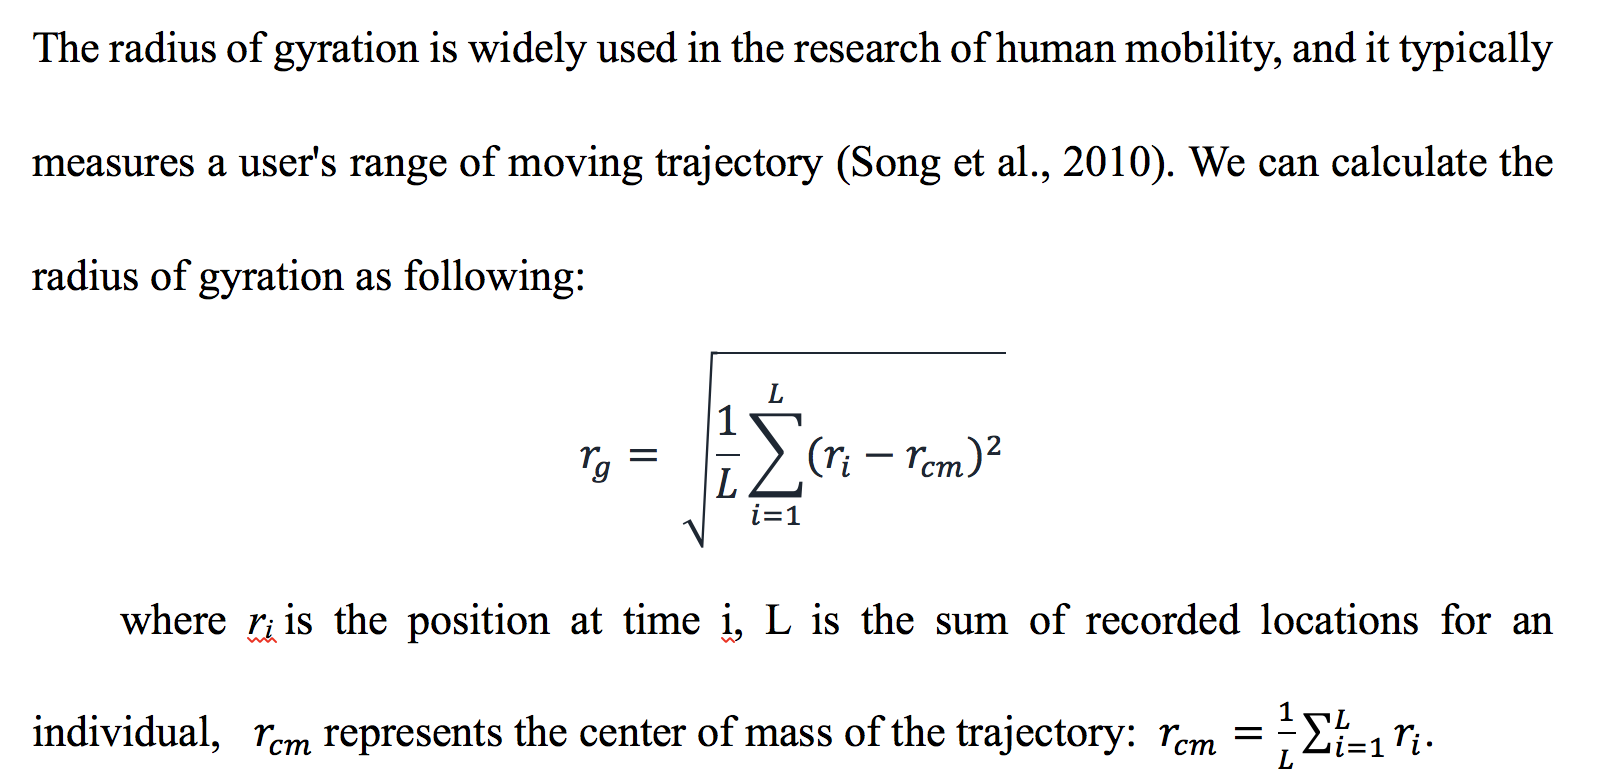

In [50]:
Image(filename = './rg.png', width=500, height=300)

In [12]:
def radius(x):
    try:
        new_names=[ '1.0','2.0','3.0','4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0', '13.0', '14.0','15.0','16.0'
              '17.0', '18.0', '19.0']
        a=[]
        for i in new_names:
            if x[i]!=1:
                a.extend(x[i])
        return np.sqrt(np.sum([i**2/len(a) for i in a]))
    except:
        return np.nan

In [14]:
data['radius']=data['raw'].apply(lambda x: radius(eval(x)))

**Radius of information cocoon except entertainment**

In [17]:
def radius_nonent(x):
        new_names=[ '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0', '13.0', '14.0','15.0','16.0'
              '17.0', '18.0', '19.0']
        a=[]
        for i in new_names:
            if x[i]!=1:
                a.extend(x[i])
        return np.sqrt(np.sum([i**2/len(a) for i in a]))

In [18]:
data['radius_nonent']=data['raw'].apply(lambda x: radius_nonent(eval(x)))

**The distance to entertainment is measured as: $\frac{Entertainment(max-min)}{All(max-min)}$, where max and min represent the maximum and minimun distance to an individual in the genre of entertainment or all the genres**

In [19]:
def game_min(x):
    try:
        new_names=['1.0','2.0','3.0']
        a=[]
        for i in new_names:
            if x[i]!=1:
                a.extend(x[i])
        return np.max(a)-np.min(a)
    except:
        np.nan

In [20]:
data['game_min']=data['raw'].apply(lambda x: game_min(eval(x)))

In [21]:
data['game_min']=data['game_min']/data['maxmin']

In [22]:
data['game_min_p']=data['game_min'].rank(pct=True,method='first')

In [23]:
def entertainment_rank(x):
    if x<=0.25:
        return 1
    if 0.25<x<=0.5:
        return 2
    if 0.5<x<=0.75:
        return 3
    if 0.75<x<=1:
        return 4
    if np.isnan(x)==True:
        return 5

In [24]:
data['game_min_rank']=data['game_min_p'].apply(lambda x: entertainment_rank(x))

**The number of category**

In [26]:
data['type_num']=data['freq'].apply(lambda x: len(eval(x)))

In [27]:
data['type_num_nonent']=data['freq'].apply(lambda x: len([i for i in eval(x) if i not in [1,2,3]]))

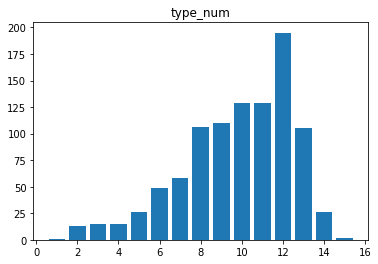

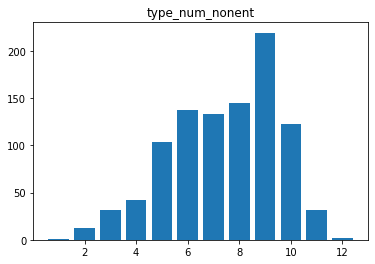

In [34]:
plt.bar(Counter(data['type_num'].values).keys(),Counter(data['type_num'].values).values())
plt.title('type_num')
plt.show()
plt.bar(Counter(data['type_num_nonent'].values).keys(),Counter(data['type_num_nonent'].values).values())
plt.title('type_num_nonent')
plt.show()

**Relative entertainment preference: $\frac{Time\,in\,entertainment}{All\,time}$**

In [25]:
for i in range(1,20):
    data['freq'+str(i)]=data['freq'].apply(lambda x: eval(x)[i] if i in eval(x) else 0)

In [28]:
data['all_freq']=data['freq'].apply(lambda x: np.sum([i for i in (eval(x)).values()]))

In [30]:
data['entertainment_freq']=data['freq1']+data['freq2']+data['freq3']

In [31]:
data['entertainment_ratio']=(data['freq1']+data['freq2']+data['freq3'])/data['all_freq']

**correlation**

In [62]:
data[['maxmin_nonent','radius','game_min_rank','type_num_nonent','entertainment_ratio']].corr()

,maxmin_nonent,radius,game_min_rank,type_num_nonent,entertainment_ratio
maxmin_nonent,1.000000,0.081031,-0.325941,0.622102,-0.083823
radius,0.081031,1.000000,0.010001,0.381051,-0.001399
game_min_rank,-0.325941,0.010001,1.000000,-0.153091,0.132621
type_num_nonent,0.622102,0.381051,-0.153091,1.000000,-0.026972
entertainment_ratio,-0.083823,-0.001399,0.132621,-0.026972,1.000000


### regression

In [36]:
data['radius_p']=data['radius'].rank(pct=True,method='first')
data['maxmin_p']=data['maxmin'].rank(pct=True,method='first')
data['maxmin_nonent_p']=data['maxmin_nonent'].rank(pct=True,method='first') # percentile can have a larger distinction
data['radius_nonent_p']=data['radius_nonent'].rank(pct=True,method='first')

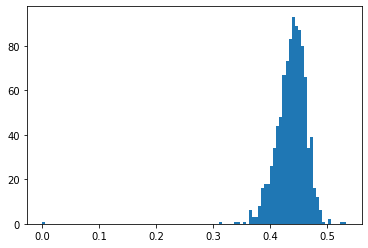

/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


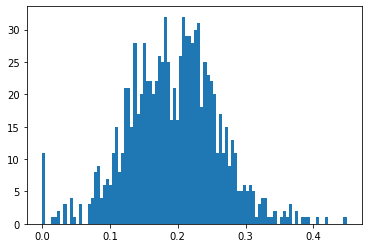

In [51]:
plt.hist(data['radius'],bins=100)
plt.show()
plt.hist(data['maxmin'],bins=100)
plt.show()

/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


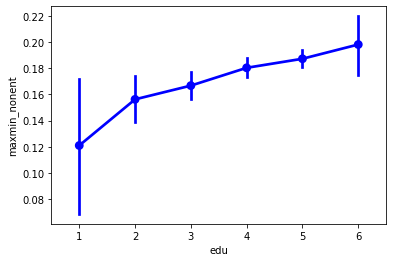

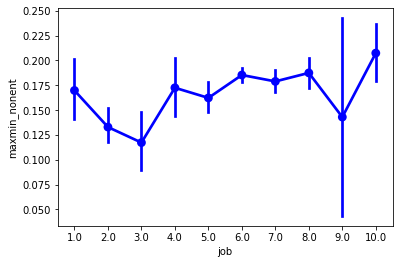

In [39]:
sns.pointplot(x="edu",y="maxmin_nonent",data=data,color='blue')
plt.show()
sns.pointplot(x="job",y="maxmin_nonent",data=data,color='blue')
plt.show()
sns.pointplot(x="income",y="maxmin_nonent",data=data,color='blue')
plt.show()

In [40]:
job = {'学生':np.nan,'其他':np.nan,'退休':np.nan, 
       '无业、下岗、失业':1,
        '农民':2,
        '农村外出务工人员':2, 
        '产业、服务业工人':3,
        '个体户/自由职业者':3,
        '企业/公司一般职员':4,'党政机关事业单位一般职员':4,
        '专业技术人员':4,
        '企业/公司管理者':5,
        '党政机关事业单位工作者':5, '党政机关事业单位领导干部':5}
data['job1'] = [job[i] for i in data['JOB']]

In [41]:
edu = {1:1,2:1,3:2,4:2,5:2,6:3}
data['edu1'] = [edu[i] for i in data['edu']]

In [42]:
inc = {'无收入':1, '500元及以下':1,'501～1000元':1,'1001～1500元':2,
 '1501～2000元':2,  '2001～3000元':2,'3001～5000元':2,
 '5001～8000元':3,'8001～12000元':3,   '12000元以上':3}
inc = {i: k+1 for k, i in enumerate(inc)}
data['income1'] = [inc[i] for i in data['INCOME']]

**number of category-social class**

In [47]:
reg = smf.ols('type_num ~ job+edu+age+male+income+entertainment_ratio',
               data = data).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               type_num   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     5.884
Date:                Mon, 06 Jul 2020   Prob (F-statistic):           5.23e-06
Time:                        12:41:37   Log-Likelihood:                -1750.8
No. Observations:                 731   AIC:                             3516.
Df Residuals:                     724   BIC:                             3548.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               8.9750      0.665     13.488      0.000       7.669      10.281
job                     0.1284      0.071      1.800      0.072      -0.012       0.268
edu                     0.2178      0.112      1.951      0.051      -0.001       0.437
age                    -0.0199      0.013     -1.563      0.118      -0.045       0.005
male                    1.2014      0.251      4.788      0.000       0.709       1.694
income                 -0.2046      0.068     -3.028      0.003      -0.337      -0.072
entertainment_ratio     1.0221      1.467      0.697      0.486      -1.859       3.903
==============================================================================
Omnibus:                       39.000   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.467
Skew:                          -0.603   Prob(JB):                     2.21e-10
Kurtosis:                       2.927   Cond. No.                         529.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**range-entertainment**

In [71]:
reg = smf.ols('maxmin_nonent ~ game_min_rank',
               data = data).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          maxmin_nonent   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     116.0
Date:                Wed, 08 Jul 2020   Prob (F-statistic):           1.22e-25
Time:                        00:40:05   Log-Likelihood:                 1258.1
No. Observations:                 978   AIC:                            -2512.
Df Residuals:                     976   BIC:                            -2502.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.2293      0.005     45.260      0.000       0.219       0.239
game_min_rank    -0.0186      0.002    -10.771      0.000      -0.022      -0.015
==============================================================================
Omnibus:                        5.584   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.061   Jarque-Bera (JB):                6.315
Skew:                           0.094   Prob(JB):                       0.0425
Kurtosis:                       3.346   Cond. No.                         7.61
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**range-social class**

In [58]:
reg = smf.ols('maxmin_nonent_p ~ job1+edu+age+male+income+city_rank+type_num',
               data = data).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        maxmin_nonent_p   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     63.04
Date:                Mon, 06 Jul 2020   Prob (F-statistic):           1.06e-70
Time:                        12:44:30   Log-Likelihood:                 50.141
No. Observations:                 731   AIC:                            -84.28
Df Residuals:                     723   BIC:                            -47.53
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4242      0.066     -6.392      0.000      -0.554      -0.294
job1           0.0296      0.012      2.486      0.013       0.006       0.053
edu            0.0199      0.010      2.077      0.038       0.001       0.039
age            0.0020      0.001      1.819      0.069      -0.000       0.004
male           0.0060      0.022      0.275      0.783      -0.037       0.049
income         0.0002      0.006      0.031      0.975      -0.012       0.012
city_rank      0.0130      0.006      2.272      0.023       0.002       0.024
type_num       0.0619      0.003     19.533      0.000       0.056       0.068
==============================================================================
Omnibus:                       22.570   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.085
Skew:                           0.445   Prob(JB):                     5.89e-06
Kurtosis:                       3.021   Cond. No.                         289.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**raidus-social class**

In [59]:
reg = smf.ols('radius_p ~ job1+edu1+age+male+income+city_rank+type_num',
               data = data).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               radius_p   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     16.82
Date:                Mon, 06 Jul 2020   Prob (F-statistic):           1.19e-20
Time:                        12:44:41   Log-Likelihood:                -72.431
No. Observations:                 731   AIC:                             160.9
Df Residuals:                     723   BIC:                             197.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3795      0.091      4.161      0.000       0.200       0.559
job1          -0.0164      0.014     -1.189      0.235      -0.043       0.011
edu1          -0.0332      0.033     -1.007      0.314      -0.098       0.032
age           -0.0006      0.001     -0.479      0.632      -0.003       0.002
male           0.0045      0.026      0.177      0.860      -0.046       0.055
income        -0.0088      0.007     -1.245      0.214      -0.023       0.005
city_rank     -0.0095      0.007     -1.409      0.159      -0.023       0.004
type_num       0.0372      0.004      9.949      0.000       0.030       0.045
==============================================================================
Omnibus:                       16.828   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               11.951
Skew:                           0.198   Prob(JB):                      0.00254
Kurtosis:                       2.514   Cond. No.                         341.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**entertainment-social class**

/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


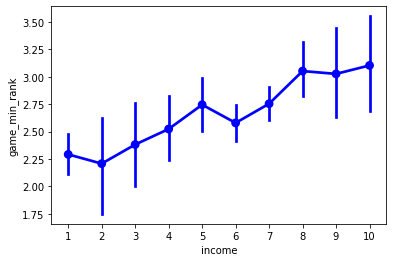

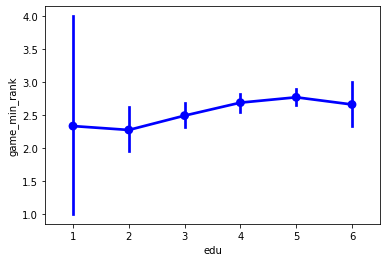

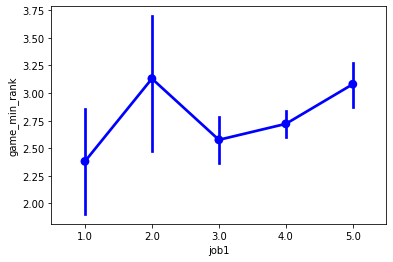

In [84]:
sns.pointplot(x="income",y="game_min_rank",data=data,color='blue')
plt.show()
sns.pointplot(x="edu",y="game_min_rank",data=data,color='blue')
plt.show()
sns.pointplot(x="job1",y="game_min_rank",data=data,color='blue')
plt.show()

In [69]:
reg = smf.ols('game_min_rank ~ job+income+edu+age+male+city_rank+entertainment_ratio',
               data = data).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          game_min_rank   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     4.275
Date:                Wed, 08 Jul 2020   Prob (F-statistic):           0.000121
Time:                        00:13:55   Log-Likelihood:                -1200.7
No. Observations:                 731   AIC:                             2417.
Df Residuals:                     723   BIC:                             2454.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               3.8053      0.331     11.509      0.000       3.156       4.454
job                    -0.0497      0.034     -1.469      0.142      -0.116       0.017
income                 -0.0074      0.033     -0.225      0.822      -0.072       0.057
edu                    -0.1452      0.053     -2.753      0.006      -0.249      -0.042
age                    -0.0045      0.006     -0.748      0.455      -0.016       0.007
male                   -0.0410      0.119     -0.346      0.729      -0.274       0.192
city_rank              -0.0231      0.032     -0.726      0.468      -0.086       0.039
entertainment_ratio     1.7962      0.692      2.596      0.010       0.438       3.155
==============================================================================
Omnibus:                       89.668   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.782
Skew:                           0.267   Prob(JB):                     1.26e-07
Kurtosis:                       2.130   Cond. No.                         533.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### random

In [96]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm

def projection(one, two):
    # cosine similarity
    return (1 - spatial.distance.cosine(one, two))

def cosine2angle(i):
    return np.arccos(i) / np.pi * 180 #长度换角度

In [97]:
TaggededDocument = gensim.models.doc2vec.TaggedDocument

In [98]:
category=pd.read_csv('./combine.csv',names=['exe','low','category'])
diction=dict(category[['low','category']].values)

In [34]:
def urlclean(url): #keep the real name of website, like taobao
    try:
        url = parse.urlparse(url).hostname
        if url.replace('.','').isdigit(): return 'none'
        else:
            if len(url.split('.')) >=2 :
                if url[-6:]=='com.cn': return '.'.join(url.split('.')[-3:])
                return '.'.join(url.split('.')[-2:])
    except:
        return 'none'

In [99]:
files=glob('./CNNIC_Clickstream1000_Data/data/users/*.csv')
node=pd.DataFrame()
for i,f in enumerate(files):
    flushPrint(i)
    data=pd.read_csv(f,names=['exe','http'])
    data['final']=data.apply(lambda x: x['exe'] if type(x.http)==float else x.http, axis=1)
    data['final']=data['final'].apply(lambda x: urlclean(x) if type(x)==str else x)
    data['low']=data['final'].apply(lambda x: x.lower() if type(x)== str else x)
    data['low1']=data['low'].apply(lambda x: re.sub('.exe','',x) if type(x)== str else x)
    data['category']=data['low1'].apply(lambda x: diction[x] if x in diction else np.nan)
    data['category']=data['category'].fillna(19.0)
    data['user']=f.split('/')[-1].split('.')[0]
    cate=data[np.isnan(data['category'])==False]
    node=node.append(cate[['user','low1','category']])

979

In [100]:
low=np.random.permutation(node[['low1','category']]) # shuffle the exe

In [101]:
node['low2']=[i[0] for i in low]
node['category2']=[i[1] for i in low]

In [102]:
node.to_csv('random_node.csv',index=False)

In [113]:
x_train=[]
for i,e in enumerate(list(set(node['user'].values))):
    flushPrint(i)
    data=node[node['user']==e]
    doc=list(data['low2'].values)
    doc_type=list(data['category2'].values)
    word_list=[]
    for j in range(len(doc)-1):
        try:
            if doc[j]!=doc[j+1]:
                word_list.extend([str(doc_type[j]),str(doc[j])])
        except:
            pass
    document = TaggededDocument(word_list, tags=[e])
    x_train.append(document)

979

In [114]:
def train(x_train, size=300, epoch_num=1):
    model_dm = Doc2Vec(x_train, size = size, dbow_words=1, min_count=1)
    model_dm.train(x_train, total_examples=model_dm.corpus_count, epochs=70)
    model_dm.save('doc2vec1_random')
    return model_dm

In [115]:
model_dm=train(x_train)

/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/gensim/models/doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [111]:
model_dm=Doc2Vec.load('doc2vec1_random')

In [118]:
radius=[]
for j in range(len(x_train)):
    flushPrint(j)
    try:
        c1=[]
        for i in range((len(x_train[j].words)+1)//2):
            c=(-projection(normalize(model_dm.docvecs[x_train[j].tags[0]]),normalize(model_dm[x_train[j].words[2*i+1]]))+1)/2
            c1.append(c)
        c2=np.sqrt(np.sum([i**2/len(c1) for i in c1]))
        c3=max(c1)-min(c1)
        radius.append([c3,c2,x_train[j].tags[0]])
    except:
        radius.append([np.nan,x_train[j].tags[0]])
        pass

979

In [119]:
d=pd.DataFrame(radius)
d.to_csv('./rg_random.csv')